<a href="https://colab.research.google.com/github/ttjh1234/Study_MLDL/blob/main/chapter07_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인공신경망

딥러닝과 인공 신경망 알고리즘을 이해하고 텐서플로를 사용해 

간단한 인공 신경망 모델을 만들어보겠다.




## 패션 MNIST

이번 장에서 사용할 데이터는 패션 MNIST 데이터셋을 사용한다.

데이터는 **텐서플로**를 사용하여 불러오겠다.


In [ ]:
from tensorflow import keras
(x_train,y_train),(x_test,y_test)=keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


**keras.datasets.fashion_mnist** 모듈 아래 **load_data()** 함수는 train_set과 test_set을 나누어 반환한다.



In [ ]:
print(x_train.shape,y_train.shape)

(60000, 28, 28) (60000,)


train_set을 보면 총 60000개의 셈플이 input 데이터는 28*28 크기의 이미지로 되어있다. 

test_set을 보면 60000개의 target 데이터로 이루어져있다.

In [ ]:
print(x_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


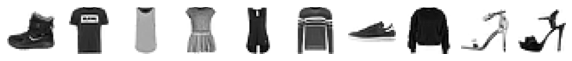

In [ ]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,10,figsize=(10,10))
for i in range(10):
  ax[i].imshow(x_train[i],cmap='gray_r')
  ax[i].axis('off')
plt.show()

리스트 내포를 사용해서 target 셋의 맨 처음 10개 데이터를 보겠다.

In [ ]:
print([y_train[i] for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


패선 MNIST 타깃은 총 0~9 까지의 클래스를 가지고있다.
각 데이터가 의미하는 것은

0. 티셔츠
1. 바지
2. 스웨터
3. 드레스
4. 코트
5. 샌달
6. 셔츠
7. 스니커즈
8. 가방
9. 앵클 부츠

이다.

In [ ]:
import numpy as np
print(np.unique(y_train,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


numpy의 **unique()** 로 확인을 해봤는데, 0~9까지 정확히 6000개의 샘플이 있다.

## 로지스틱 회귀로 패션 아이템 분류하기

이 train_set은 60000개나 되기 때문에 전체 데이터를 한꺼번에 사용하는 것보다 

샘플을 하나씩 꺼내서 모델을 훈련하는 방법을 사용한다.

=> **확률적 경사 하강법**

**SGDClassifier** 클래스의 **loss** 매개변수를 'log' 로 지정하여 

로지스틱 손실 함수를 최소화하는 확률적 경사 하강법을 사용하겠다.

시작에 앞서 확률적 경사 하강법을 사용하면 손실함수를 사용하기 때문에, 

각 데이터의 스케일을 맞춰주어야 한다.

이번 장에서는 전체 데이터를 0~1사이값으로 정규화 하여 사용하겠다.



In [ ]:
print(x_train.shape)

(60000, 28, 28)


In [ ]:
x_train_scaled=x_train/255.0
x_train_scaled=x_train_scaled.reshape(-1,28*28)
print(x_train_scaled.shape)

(60000, 784)


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
sc=SGDClassifier(loss='log',max_iter=5,random_state=42)
scores=cross_validate(sc,x_train_scaled,y_train,n_jobs=-1)
print(np.mean(scores['test_score']))

0.8195666666666668


## 인공신경망

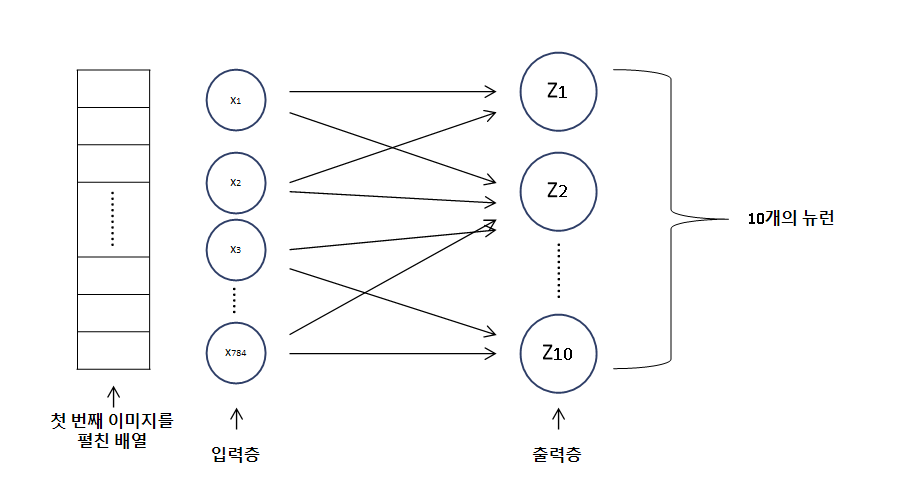

출력층 : z1~z10 을 계산하고 이를 바탕으로 클래스를 예측하기 때문에 

신경망의 최종 값을 만든다는 의미로 출력층이라고 불린다.

뉴런(유닛) : 인공 신경망에서 z 값을 계산하는 단위를 뉴런이라고 한다.

입력층 : x1~x784 까지를 입력층이라고 부른다. 

인공신경망은 1943년 워런 매컬러와 월터 피츠가 제안한 뉴런 모델이다. 



### 텐서플로와 케라스

**텐서플로**는 구글이 2015년 11월 오픈소스로 공개한 딥러닝 라이브러리이다.

텐서플로에는 **저수준 API** 와 **고수준 API**가 있다.

케라스가 텐서플로의 고수준 API이다.

딥러닝 라이브러리가 다른 머신러닝 라이브러리와 다른 점 중 하나는 그래픽 처리 장치인 GPU를 사용.


In [ ]:
import tensorflow as tf
from tensorflow import keras

## 인공 신경망으로 모델 만들기

앞서 로지스틱 회귀에서는 교차 검증을 사용해 모델을 평가했지만,

인공 신경망에서는 교차 검증을 사용하지 않고, 검증 세트를 별도로 덜어내어 사용한다.

이유는
1.  딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증 점수가 안정적이기 때문이다.
2.  교차 검증을 수행하기에는 훈련시간이 너무 오래 걸리기 때문이다.

따라서 sklearn의 **train_test_split()** 함수를 사용하여 나누어보겠다.

In [ ]:
from sklearn.model_selection import train_test_split
x_train_scaled,x_valid,y_train,y_valid=train_test_split(x_train_scaled,y_train,test_size=0.2,random_state=42)
print(x_train_scaled.shape,y_train.shape)

(48000, 784) (48000,)


In [ ]:
print(x_valid.shape,y_valid.shape)

(12000, 784) (12000,)


케라스의 레이어(keras.layers) 패키지 안에는 다양한 층이 준비되어 있다.

가장 기본이 되는 층은 **밀집층(dense layer)** 이다.

왼쪽에 있는 784개의 픽셀과 오른쪽에 있는 10개의 뉴런이 모두 연결되면 

총 7840개의 연결된 선의 있다.

이른 청을 양쪽의 뉴런이 모두 연결하고 있기 때문에 **완전 연결층** 이라고 한다.

케라스에서는 **Dense** 클래스를 사용해 밀집층을 만들 수 있다.

필요한 매개변수는 뉴런 개수, 뉴런의 출력에 적용할 함수, 입력의 크기 이다.


In [ ]:
dense=keras.layers.Dense(10,activation='softmax',input_shape=(784,))

위에서 만든 밀집층을 만든 후, 이 밀집층을 가진 신경망 모델을 만드려면,

케라스의 **Sequential** 클래스를 사용한다.

위에서 소프트맥수와 같이 뉴런의 선형 방정식 계산 결과에 적용되는 함수를 **활성화 함수**라고 부른다.


In [ ]:
model=keras.Sequential(dense)

## 인공 신경망으로 패션 아이템 분류하기

sklearn에 비해 케라스에서 모델을 만드는 방식은 조금 다르다.

케라스 모델은 훈련하기 전에 설정 단계가 있다.

model 객체의 compile() 메서드에서 설정을 진행한다.

꼭 지정해야하는 것은 확률적 경사 하강법 처럼 손실 함수를 지정해야 한다.

다중분류에서 손실함수를 적게 하기 위해 예측 타깃 값은 1로 나머지는 0으로 만드는 

희소행렬(배열)을 만드는 것이 중요하다.

따라서 해당 클래스만 1이고, 나머지는 0인 배열로 만드는 **원 핫 인코딩** 변환이라고 한다.

텐서플로에서는 정수로 된 타깃값을 원-핫 인코딩으로 바꾸지 않고 그냥 사용할 수 있다.

정수로된 타깃값을 사용해 크로스엔트로피 손실을 계산하는 것이 바로 

**'sparse_categorical_crossentropy'** 이다.

만약 타깃값을 원-핫 인코딩으로 바꾸었으면 손실 함수에 **categorical_crossentropy**로 지정한다.

두 번째 매개변수인 metrics를 알아보자.

케라스는 모델이 훈련할 때 기본적으로 에포크마다 손실 값을 출력해준다.

손실이 줄어드는 것을 보고 훈련이 잘되었다는 것을 알 수 있지만,

정확도를 같이 출력하면 더 좋을 것이다.

따라서 metrics 매개변수에 **'accuracy'** 를 지정하여 표현하도록 한다.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy')

In [ ]:
model.fit(x_train_scaled,y_train,epochs=5)

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.7906 - accuracy: 0.7329
Epoch 2/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4817 - accuracy: 0.8368
Epoch 3/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4607 - accuracy: 0.8461
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4452 - accuracy: 0.8519
Epoch 5/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4289 - accuracy: 0.8577


In [ ]:
model.evaluate(x_valid,y_valid)

375/375 [==============================] - 1s 2ms/step - loss: 0.4565 - accuracy: 0.8451


[0.45648452639579773, 0.8450833559036255]